# Overview

The task at hand is classification of terrain types from satellite images.
We will use two different approaches:
- A "standard" transfer learning approach where we will build a CNN using a base model (from Imagenet)
- A "bayesian" approach where we will take into account uncertainty on the provided labels

## Workflow

1. [Data Inspection](#inspection) 
    - Loading
    - Inspection
    - Preprocessing
2. [Modeling](#model-definition)
    - Convolutional Neural Network
    - Bayesian Neural Network
3. [Prediction](#prediction)

In [3]:
# Software install (as required)
#!pip install -r ../requirements.txt

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa

2023-04-03 14:33:46.164248: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-03 14:33:48.476273: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-03 14:33:48.477211: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 14:33:52.344831: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/codespace/.p

## Data Inspection <a name="inspection"></a>

In [5]:
# Data Loading : load the EuroSat dataset
# 27000 Sentinel-2 satellite images covering 13 spectral bands. 
# Reference : https://github.com/phelber/eurosat

# load train, test & validation splits into 60%, 20%,20% respectively
(ds_train, ds_test, ds_valid), ds_info   = tfds.load(
    "eurosat", 
    split=["train[:60%]","train[60%:80%]","train[80%:]"],
    as_supervised=True,
    shuffle_files=True,
    with_info=True)

In [6]:
ds_info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [7]:
# Basic Info
class_names = ds_info.features["label"].names
num_classes = ds_info.features["label"].num_classes
image_size  = ds_info.features["image"]
print('Total no. of classes : %d' %num_classes)
print('Class labels  : %s' %class_names)
print("Total examples: %d" %(len(ds_valid)+len(ds_train)+len(ds_test)))
print("Train set size: %d" %len(ds_train)) 
print("Test set size : %d" %len(ds_test))   
print("Valid set size: %d" %len(ds_valid))
print("")
ds = ds_train.take(1)  # Only take a single example
for image, label in ds: 
  print('image tensor shape: %s' %image.shape)
  print('label tensor type: %s' %label)

Total no. of classes : 10
Class labels  : ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total examples: 27000
Train set size: 16200
Test set size : 5400
Valid set size: 5400



2023-04-03 14:33:59.811370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-04-03 14:33:59.812223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


image tensor shape: (64, 64, 3)
label tensor type: tf.Tensor(1, shape=(), dtype=int64)


2023-04-03 14:34:00.046183: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2023-04-03 14:34:06.073070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-04-03 14:34:06.073703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-04-03 14:34:06.113488: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

,image,label
0,,1 (Forest)
1,,7 (Residential)
2,,2 (HerbaceousVegetation)
3,,7 (Residential)
4,,1 (Forest)
5,,0 (AnnualCrop)
6,,8 (River)
7,,0 (AnnualCrop)
8,,1 (Forest)
9,,7 (Residential)

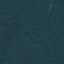
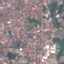
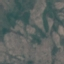
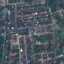
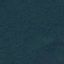
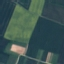
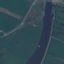
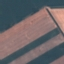
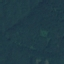
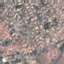

In [8]:
# show a few examples from the train dataset
tfds.as_dataframe(ds_train.take(10), ds_info)

2023-04-03 14:35:55.208597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-04-03 14:35:55.209104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


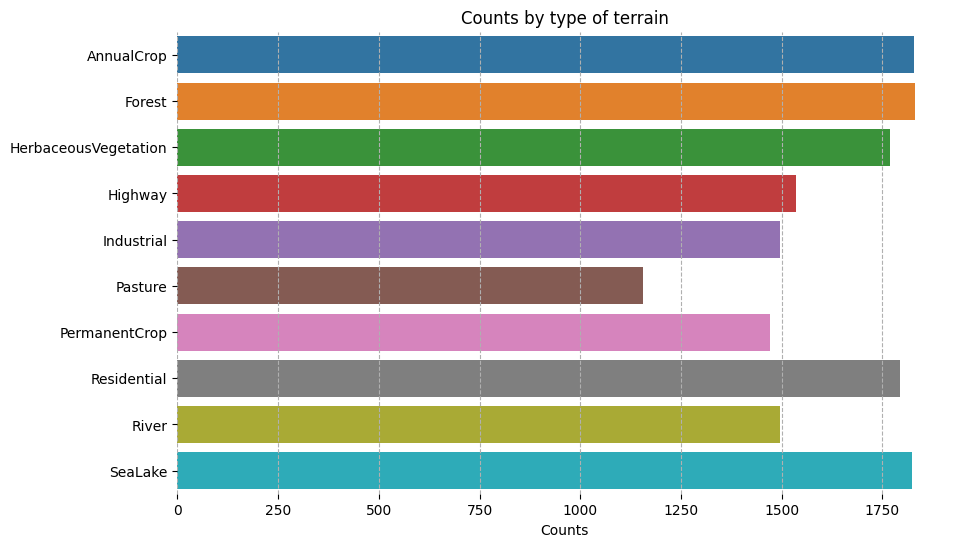

In [13]:
# Class balance check : is the dataset imbalanced?
fig, ax = plt.subplots(1, 1, figsize=(10,6))

labels, counts = np.unique(np.fromiter(ds_train.map(lambda x, y: y), np.int32), 
                       return_counts=True)
ax.set_xlabel('Counts')
ax.grid(True,ls='--')
ax.set_title("Counts by type of terrain");
sns.barplot(x=counts, y=[class_names[l] for l in labels], label="Total")
sns.despine(left=True, bottom=True)

In [14]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # one-hot encode labels
  ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes)))
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [15]:
batch_size = 64
# preprocess training & validation sets
ds_train = prepare_for_training(ds_train, batch_size=batch_size)
ds_valid = prepare_for_training(ds_valid, batch_size=batch_size)

TypeError: in user code:


    TypeError: outer_factory.<locals>.inner_factory.<locals>.<lambda>() takes 1 positional argument but 2 were given


### Model Definition <a name="model definition"></a>

  1. We use a base model (pretrained neural net for the imagenet challenge and specify that is trainable
  2. We add a top model with a softmax classification layer 

In [ ]:
# BASE MODEL
model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2"
# download & load the layer as a feature vector
base_model = hub.KerasLayer(model_url, output_shape=[1280], trainable=True, name='base_layer')

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(num_classes, activation="softmax", name="classification_layer")
])
# build the model with input image shape as (64, 64, 3)
model.build([None, 64, 64, 3])
model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy", tfa.metrics.F1Score(num_classes)]
)

In [ ]:
model.summary()

In [ ]:
model_name = "satellite-classification"
model_path = os.path.join("../models", model_name + ".h5")
if not os.path.exists("../models"):
    os.makedirs(model_path)

In [ ]:
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps   = int(num_examples * 0.6) // batch_size
# number of validation steps
n_validation_steps = int(num_examples * 0.2) // batch_size

### Model Training <a name="model training"></a>

In [ ]:
verbose=1
epochs=5
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)
# train the model
history = model.fit(
    train_ds, validation_data=valid_ds,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    verbose=verbose, epochs=epochs, 
    callbacks=[model_checkpoint]
)

### Model Evaluation <a name="model evaluation"></a>